In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Load the dataset from Kaggle
file_path = 'C:/Users/krkr5/OneDrive/바탕 화면/project/Crypto_data/dava_csv/SOL_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to ensure it is loaded correctly
data.head()

,open_time,open,high,low,close,volume
0,2023-07-10 15:00:00,21.17,21.19,21.13,21.14,11640.49
1,2023-07-10 15:01:00,21.14,21.17,21.11,21.11,5304.66
2,2023-07-10 15:02:00,21.12,21.12,21.09,21.11,4088.15
3,2023-07-10 15:03:00,21.11,21.14,21.10,21.14,7810.10
4,2023-07-10 15:04:00,21.15,21.17,21.11,21.11,2510.23


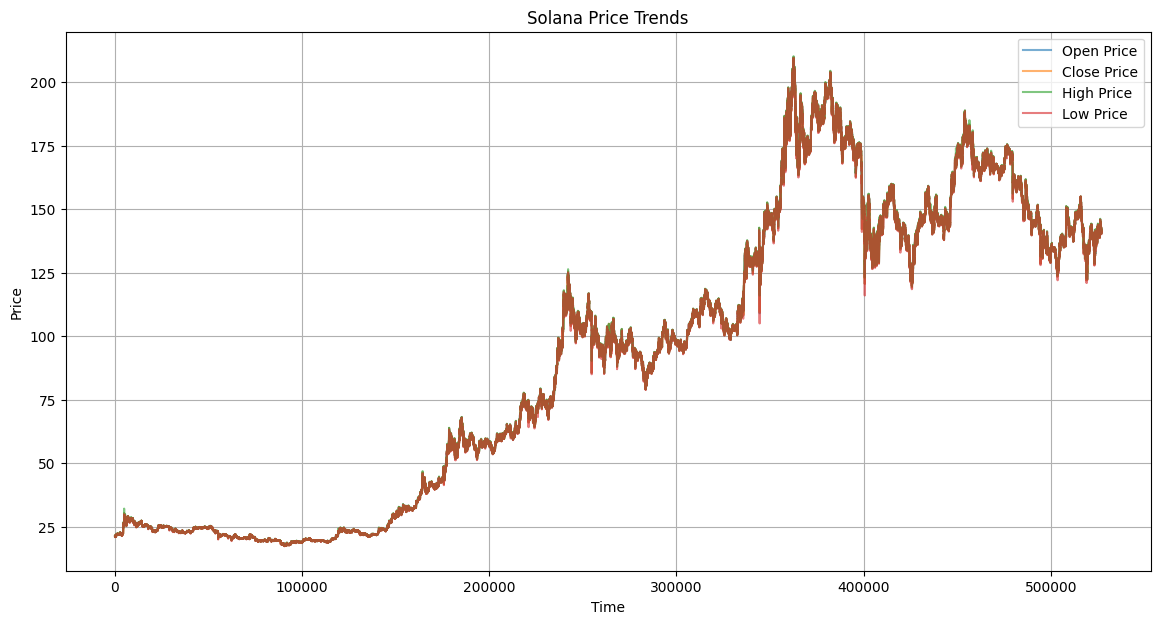

In [3]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['open'], label='Open Price', alpha=0.6)
plt.plot(data.index, data['close'], label='Close Price', alpha=0.6)
plt.plot(data.index, data['high'], label='High Price', alpha=0.6)
plt.plot(data.index, data['low'], label='Low Price', alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Solana Price Trends')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# TensorFlow가 GPU를 인식하는지 확인
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("GPU details: ", tf.config.experimental.list_physical_devices('GPU'))

Num GPUs Available:  0
GPU details:  []


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 텐서플로가 첫 번째 GPU만 사용하도록 제한
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU 설정 완료")
    except RuntimeError as e:
        # 메모리 증가가 설정된 후에는 장치를 수정할 수 없습니다
        print(e)

In [ ]:
#RSI 10 20 60  계산

def calculate_rsi(data, window):
    delta = data.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    avg_gain = pd.Series(gain).rolling(window=window, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

data['RSI_10'] = calculate_rsi(data['close'], 10)
data['RSI_20'] = calculate_rsi(data['close'], 20)
data['RSI_60'] = calculate_rsi(data['close'], 60)

In [ ]:
#MACD(12,26,9)

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    # Calculate the short term exponential moving average (EMA)
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    # Calculate the long term exponential moving average (EMA)
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    # Calculate the MACD line
    macd_line = short_ema - long_ema
    # Calculate the signal line
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    # Calculate the MACD histogram
    macd_histogram = macd_line - signal_line
    
    return macd_line, signal_line, macd_histogram

# Calculate MACD values
data['MACD_Line'], data['Signal_Line'], data['MACD_Histogram'] = calculate_macd(data['close'])

In [ ]:
#CCI 5 10 20

def calculate_cci(data, window):
    tp = (data['high'] + data['low'] + data['close']) / 3
    sma = tp.rolling(window=window).mean()
    mad = (tp - sma).abs().rolling(window=window).mean()
    cci = (tp - sma) / (0.015 * mad)
    
    return cci

# Calculate CCI for different windows
data['CCI_5'] = calculate_cci(data, 5)
data['CCI_10'] = calculate_cci(data, 10)
data['CCI_20'] = calculate_cci(data, 20)

In [ ]:
#RSI STOCHASTIC 10 20 60

def calculate_rsi_stochastics(data, rsi_window, k_window, d_window):
    rsi = calculate_rsi(data['close'], rsi_window)
    lowest_rsi = rsi.rolling(window=k_window).min()
    highest_rsi = rsi.rolling(window=k_window).max()
    
    rsi_stochastic_k = 100 * ((rsi - lowest_rsi) / (highest_rsi - lowest_rsi))
    rsi_stochastic_d = rsi_stochastic_k.rolling(window=d_window).mean()
    
    return rsi_stochastic_k, rsi_stochastic_d

# Calculate RSI-Stochastics for different RSI windows
data['RSI_Stoch_K_10'], data['RSI_Stoch_D_10'] = calculate_rsi_stochastics(data, 10, 3, 3)
data['RSI_Stoch_K_20'], data['RSI_Stoch_D_20'] = calculate_rsi_stochastics(data, 20, 3, 3)
data['RSI_Stoch_K_60'], data['RSI_Stoch_D_60'] = calculate_rsi_stochastics(data, 60, 3, 3)

In [ ]:
#MFI 10 20 60

def calculate_mfi(data, window):
    typical_price = (data['high'] + data['low'] + data['close']) / 3
    money_flow = typical_price * data['volume']
    
    positive_flow = money_flow.copy()
    negative_flow = money_flow.copy()
    
    for i in range(1, len(typical_price)):
        if typical_price[i] > typical_price[i-1]:
            negative_flow[i] = 0
        else:
            positive_flow[i] = 0
    
    positive_mf = positive_flow.rolling(window=window).sum()
    negative_mf = negative_flow.rolling(window=window).sum()
    
    mfi = 100 - (100 / (1 + (positive_mf / negative_mf)))
    
    return mfi

# Calculate MFI for different windows
data['MFI_10'] = calculate_mfi(data, 10)
data['MFI_20'] = calculate_mfi(data, 20)
data['MFI_60'] = calculate_mfi(data, 60)

In [ ]:
#VR 10 20 60

def calculate_volume_ratio(data, window):
    volume_ratio = data['volume'] / data['volume'].rolling(window=window).mean()
    return volume_ratio

# Calculate Volume Ratio for different windows
data['Volume_Ratio_10'] = calculate_volume_ratio(data, 10)
data['Volume_Ratio_20'] = calculate_volume_ratio(data, 20)
data['Volume_Ratio_60'] = calculate_volume_ratio(data, 60)

In [ ]:
#Bollinger Band 10 20 60

def calculate_bollinger_bands(data, window):
    rolling_mean = data['close'].rolling(window=window).mean()
    rolling_std = data['close'].rolling(window=window).std()
    
    upper_band = rolling_mean + (rolling_std * 2)
    lower_band = rolling_mean - (rolling_std * 2)
    
    return rolling_mean, upper_band, lower_band

# Calculate Bollinger Bands for different windows
data['BB_Mean_10'], data['BB_Upper_10'], data['BB_Lower_10'] = calculate_bollinger_bands(data, 10)
data['BB_Mean_20'], data['BB_Upper_20'], data['BB_Lower_20'] = calculate_bollinger_bands(data, 20)
data['BB_Mean_60'], data['BB_Upper_60'], data['BB_Lower_60'] = calculate_bollinger_bands(data, 60)

In [ ]:
#Ichimoku Cloud (9 26 52)

def calculate_ichimoku(data, short_window, medium_window, long_window):
    # Calculate Tenkan-Sen (Conversion Line)
    high_short = data['high'].rolling(window=short_window).max()
    low_short = data['low'].rolling(window=short_window).min()
    data['Tenkan_Sen'] = (high_short + low_short) / 2

    # Calculate Kijun-Sen (Base Line)
    high_medium = data['high'].rolling(window=medium_window).max()
    low_medium = data['low'].rolling(window=medium_window).min()
    data['Kijun_Sen'] = (high_medium + low_medium) / 2

    # Calculate Senkou Span A (Leading Span A)
    data['Senkou_Span_A'] = ((data['Tenkan_Sen'] + data['Kijun_Sen']) / 2).shift(medium_window)

    # Calculate Senkou Span B (Leading Span B)
    high_long = data['high'].rolling(window=long_window).max()
    low_long = data['low'].rolling(window=long_window).min()
    data['Senkou_Span_B'] = ((high_long + low_long) / 2).shift(medium_window)

    # Calculate Chikou Span (Lagging Span)
    data['Chikou_Span'] = data['close'].shift(-medium_window)

    return data

# Calculate Ichimoku Cloud components
data = calculate_ichimoku(data, 9, 26, 52)

In [ ]:
#Envelope 10 20 60

def calculate_envelope(data, window, percentage=0.025):
    moving_average = data['close'].rolling(window=window).mean()
    upper_band = moving_average * (1 + percentage)
    lower_band = moving_average * (1 - percentage)
    
    return moving_average, upper_band, lower_band

# Calculate Envelope for different windows
data['Envelope_MA_10'], data['Envelope_Upper_10'], data['Envelope_Lower_10'] = calculate_envelope(data, 10)
data['Envelope_MA_20'], data['Envelope_Upper_20'], data['Envelope_Lower_20'] = calculate_envelope(data, 20)
data['Envelope_MA_60'], data['Envelope_Upper_60'], data['Envelope_Lower_60'] = calculate_envelope(data, 60)

In [ ]:
def calculate_fibo_retracement(data, fibo_length=144, indicator_length=14, source='close', indicator_type='RSI'):
    # Ensure volume column is present if necessary
    if 'volume' not in data.columns:
        raise ValueError("Volume data is required for certain indicators but not provided.")
    
    # Function to calculate the chosen indicator
    def get_indicator(data, length, indicator_type):
        if indicator_type == 'RSI':
            delta = data[source].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=length).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=length).mean()
            rs = gain / loss
            return 100 - (100 / (1 + rs))
        elif indicator_type == 'CCI':
            tp = (data['high'] + data['low'] + data[source]) / 3
            return (tp - tp.rolling(window=length).mean()) / (0.015 * tp.rolling(window=length).std())
        elif indicator_type == 'MFI':
            tp = (data['high'] + data['low'] + data[source]) / 3
            mf = tp * data['volume']
            positive_mf = mf.where(data[source].diff() > 0, 0)
            negative_mf = mf.where(data[source].diff() < 0, 0)
            mfi = 100 - (100 / (1 + (positive_mf.rolling(window=length).sum() / negative_mf.rolling(window=length).sum())))
            return mfi
        elif indicator_type == 'STOCHASTIC':
            lowest_low = data['low'].rolling(window=length).min()
            highest_high = data['high'].rolling(window=length).max()
            return 100 * (data[source] - lowest_low) / (highest_high - lowest_high)
        elif indicator_type == 'CMF':
            mfv = ((2 * data['close'] - data['low'] - data['high']) / (data['high'] - data['low'])) * data['volume']
            return mfv.rolling(window=length).sum() / data['volume'].rolling(window=length).sum()
        elif indicator_type == 'CMO':
            diff = data[source].diff()
            return 100 * (diff.rolling(window=length).apply(lambda x: np.sum(x[x > 0]) - np.sum(x[x < 0])) /
                          diff.rolling(window=length).apply(lambda x: np.sum(np.abs(x))))
        else:
            raise ValueError(f"Unknown indicator type: {indicator_type}")

    # Calculate the chosen indicator
    data['INDICATOR'] = get_indicator(data, indicator_length, indicator_type)

    # Calculate highest and lowest points
    data['high_ind'] = data['INDICATOR'].rolling(window=fibo_length).max()
    data['low_ind'] = data['INDICATOR'].rolling(window=fibo_length).min()

    # Calculate the Fibonacci retracement levels
    data['diff'] = data['high_ind'] - data['low_ind']
    fib_levels = [0.236, 0.382, 0.5, 0.618, 0.786, 1.272, 1.618, 2.618, 3.618]

    for level in fib_levels:
        data[f'fib_{level}'] = data['low_ind'] + data['diff'] * level
        data[f'fib_{-level}'] = data['high_ind'] - data['diff'] * level

    return data

# Apply the function to the data
result = calculate_fibo_retracement(data, fibo_length=144, indicator_length=14, source='close', indicator_type='RSI')

In [ ]:
#1시간씩 간격을 나누어서 종가 기준으로 최대 상승 및 하락하는 %를 구하는

# Convert 'open_time' to datetime format
data['open_time'] = pd.to_datetime(data['open_time'])

# Set 'open_time' as the index for easier manipulation
solana_data.set_index('open_time', inplace=True)

# Resample data to 1-minute frequency to ensure continuous time range without missing minutes
solana_data = solana_data.resample('min').ffill()

# Convert DataFrame to TensorFlow tensor
close_prices = tf.constant(solana_data['close'].values, dtype=tf.float32)
high_prices = tf.constant(solana_data['high'].values, dtype=tf.float32)
low_prices = tf.constant(solana_data['low'].values, dtype=tf.float32)
index_values = solana_data.index

# Initialize lists to store results
results = {
    30: {'rise_percentages': [], 'fall_percentages': [], 'rise_times': [], 'fall_times': [], 'start_times': [], 'end_times': []},
    60: {'rise_percentages': [], 'fall_percentages': [], 'rise_times': [], 'fall_times': [], 'start_times': [], 'end_times': []}
}

total_length = len(solana_data)

# 벡터화 연산을 사용하여 데이터 처리 (30분과 60분 차이만 고려)
for interval in [30, 60]:
    if interval < total_length:
        high_prices_matrix = tf.stack([high_prices[i:i + interval + 1] for i in range(total_length - interval)], axis=0)
        low_prices_matrix = tf.stack([low_prices[i:i + interval + 1] for i in range(total_length - interval)], axis=0)
        
        max_prices = tf.reduce_max(high_prices_matrix, axis=1)
        min_prices = tf.reduce_min(low_prices_matrix, axis=1)

        start_closes = close_prices[:total_length - interval]
        end_times_batch = index_values[interval:total_length]

        rise_percentages_batch = (max_prices - start_closes) / start_closes * 100
        fall_percentages_batch = (start_closes - min_prices) / start_closes * 100

        max_indices = tf.argmax(high_prices_matrix, axis=1).numpy() + np.arange(total_length - interval)
        min_indices = tf.argmin(low_prices_matrix, axis=1).numpy() + np.arange(total_length - interval)

        results[interval]['rise_percentages'].extend(rise_percentages_batch.numpy())
        results[interval]['fall_percentages'].extend(fall_percentages_batch.numpy())
        results[interval]['rise_times'].extend(index_values[max_indices])
        results[interval]['fall_times'].extend(index_values[min_indices])
        results[interval]['start_times'].extend(index_values[:total_length - interval])
        results[interval]['end_times'].extend(end_times_batch)

    # Calculate and print progress
    progress = (interval / 60) * 100
    print(f"Progress: {progress:.2f}%")

# Create a new DataFrame with the calculated rise and fall percentages and corresponding time indices for 30 minutes and 60 minutes
result_df_30 = pd.DataFrame({
    'start_time': results[30]['start_times'],
    'end_time': results[30]['end_times'],
    'rise_percentage': results[30]['rise_percentages'],
    'fall_percentage': results[30]['fall_percentages'],
    'rise_time': results[30]['rise_times'],
    'fall_time': results[30]['fall_times']
})

result_df_60 = pd.DataFrame({
    'start_time': results[60]['start_times'],
    'end_time': results[60]['end_times'],
    'rise_percentage': results[60]['rise_percentages'],
    'fall_percentage': results[60]['fall_percentages'],
    'rise_time': results[60]['rise_times'],
    'fall_time': results[60]['fall_times']
})

In [ ]:
result_df_30.head()

In [ ]:
result_df_60.head()

In [ ]:
# 저장할 경로 설정
save_path1 = '/kaggle/working/BTC30_rise_fall_percentages.csv'
save_path2 = '/kaggle/working/BTC60_rise_fall_percentages.csv'

# CSV 파일로 저장
result_df_30.to_csv(save_path1, index=False)
result_df_60.to_csv(save_path2, index=False)

In [ ]:
df = pd.read_csv(save_path1)

In [ ]:
# 데이터 시간 처리
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['rise_time'] = pd.to_datetime(df['rise_time'])
df['fall_time'] = pd.to_datetime(df['fall_time'])

# 날짜를 무시하고 시간 데이터만 활용하여 시간과 분으로 묶습니다.
df['start_hour'] = df['start_time'].dt.hour
df['start_minute'] = df['start_time'].dt.minute

# 1.2% 이상 상승하는 비율을 계산합니다.
rise_above_1_2 = df['rise_percentage'] >= 1.2

# 1.2% 이상 상승하는 비율
rise_above_1_2_ratio = rise_above_1_2.mean()

# 각 시간대별 통계 계산
df['time_diff'] = (df['rise_time'] - df['start_time']).dt.total_seconds() / 60  # 분 단위 시간 차이

grouped = df.groupby(['start_hour', 'start_minute'])

statistics = grouped.agg(
    avg_rise_percentage=('rise_percentage', 'mean'),
    max_rise_percentage=('rise_percentage', 'max'),
    avg_fall_percentage=('fall_percentage', 'mean'),
    max_fall_percentage=('fall_percentage', 'max'),
    avg_time_diff=('time_diff', 'mean'),
    rise_above_1_2_ratio=('rise_percentage', lambda x: (x >= 1.2).mean())
).reset_index()

In [ ]:
sorted_statistics = statistics.sort_values(by='rise_above_1_2_ratio', ascending=False).reset_index(drop=True)
sorted_statistics.head()

In [ ]:
df2 = pd.read_csv(save_path2)

In [ ]:
# 데이터 시간 처리
df2['start_time'] = pd.to_datetime(df2['start_time'])
df2['end_time'] = pd.to_datetime(df2['end_time'])
df2['rise_time'] = pd.to_datetime(df2['rise_time'])
df2['fall_time'] = pd.to_datetime(df2['fall_time'])

# 날짜를 무시하고 시간 데이터만 활용하여 시간과 분으로 묶습니다.
df2['start_hour'] = df2['start_time'].dt.hour
df2['start_minute'] = df2['start_time'].dt.minute

# 1.2% 이상 상승하는 비율을 계산합니다.
rise_above_1_22 = df['rise_percentage'] >= 1.2

# 1.2% 이상 상승하는 비율
rise_above_1_2_ratio2 = rise_above_1_22.mean()

# 각 시간대별 통계 계산
df2['time_diff'] = (df2['rise_time'] - df2['start_time']).dt.total_seconds() / 60  # 분 단위 시간 차이

# 그룹화 및 집계 수행
grouped = df2.groupby(['start_hour', 'start_minute'])

statistics2 = grouped.agg(
    avg_rise_percentage=('rise_percentage', 'mean'),
    max_rise_percentage=('rise_percentage', 'max'),
    avg_fall_percentage=('fall_percentage', 'mean'),
    max_fall_percentage=('fall_percentage', 'max'),
    avg_time_diff=('time_diff', 'mean'),
    rise_above_1_2_ratio2=('rise_percentage', lambda x: (x >= 1.2).mean())
).reset_index()

In [ ]:
sorted_statistics2 = statistics2.sort_values(by='rise_above_1_2_ratio2', ascending=False).reset_index(drop=True)
sorted_statistics2.head()